## 1)Load the packages

In [12]:
import numpy as np
import pandas as pd
import itertools
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator, 
                           Scenario, Constraint, Policy,
                           Constant,RealParameter,IntegerParameter,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import (perform_experiments, optimize,
                                                   BaseEvaluator)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline

ema_logging.log_to_stderr(ema_logging.INFO)

BaseEvaluator.reporting_frequency = 0.01

## 2) Load results

In [13]:
dike_model,planning_steps = get_model_for_problem_formulation(0)

In [4]:
dike_model.levers = [IntegerParameter('0_RfR 0',0,1),IntegerParameter('0_RfR 1',0,1),
                     IntegerParameter('1_RfR 0',0,1),IntegerParameter('1_RfR 1',0,1),
                     IntegerParameter('3_RfR 0',0,1),IntegerParameter('3_RfR 1',0,1),
                     IntegerParameter('4_RfR 0',0,1),IntegerParameter('4_RfR 1',0,1),
                     IntegerParameter('A.1_DikeIncrease 1',0,10),IntegerParameter('A.2_DikeIncrease 1',0,10),
                     IntegerParameter('A.3_DikeIncrease 1',0,10),IntegerParameter('A.5_DikeIncrease 1',0,3)]

In [7]:
dike_model.constants = [Constant('EWS_DaysToThreat',0), Constant('A.1_DikeIncrease 0',10),Constant('A.2_DikeIncrease 0',9),
                        Constant('A.3_DikeIncrease 0',10),Constant('A.4_DikeIncrease 0',5), Constant('A.4_DikeIncrease 1',3), 
                        Constant('A.5_DikeIncrease 0',3)]

In [8]:
dike_model.outcomes = [ScalarOutcome('A.4_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Annual Damage 1',kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('A.4_Expected Number of Deaths 1',kind=ScalarOutcome.MINIMIZE)]

In [17]:
results = load_results('MORO4pol_lessdikeheightnorfrG.tar.gz')
experiment,_ = results
results_df = pd.DataFrame.from_dict(_) 


[MainProcess/INFO] results loaded succesfully from C:\Users\pvbia\OneDrive\Documentos\GitHub\MBDM-group-11\final assignment\MORDM_weak\MORO4pol_lessdikeheightnorfrG.tar.gz


## 3)Parallel coordinate plot

In [18]:
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']
results_df.head()

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_Expected Number of Deaths 1,A.4_Expected Annual Damage 1,A.4_Dike Investment Costs 1,A.4_Expected Number of Deaths 1,A.5_Expected Annual Damage 1,A.5_Dike Investment Costs 1,A.5_Expected Number of Deaths 1,RfR Total Costs 1,Expected Evacuation Costs 1,name
0,0.0,6.071731e+07,0.0,0.0,8.999201e+07,0.0,0.0,4.421502e+07,0.0,0.0,...,0.0,0.0,8.673386e+06,0.0,0.000000e+00,0,0.000000,30700000.0,0.0,policy1
1,0.0,6.071731e+07,0.0,0.0,8.999201e+07,0.0,0.0,4.421502e+07,0.0,0.0,...,0.0,0.0,8.673386e+06,0.0,1.268603e+06,0,0.001689,30700000.0,0.0,policy1
2,0.0,6.071731e+07,0.0,0.0,8.999201e+07,0.0,0.0,4.421502e+07,0.0,0.0,...,0.0,0.0,8.673386e+06,0.0,1.039580e+08,0,0.104482,30700000.0,0.0,policy1
3,0.0,6.071731e+07,0.0,0.0,8.999201e+07,0.0,0.0,4.421502e+07,0.0,0.0,...,0.0,0.0,8.673386e+06,0.0,8.512066e+06,0,0.011273,30700000.0,0.0,policy1
4,0.0,6.071731e+07,0.0,0.0,8.999201e+07,0.0,0.0,4.421502e+07,0.0,0.0,...,0.0,0.0,8.673386e+06,0.0,8.583187e+06,0,0.011373,30700000.0,0.0,policy1


In [25]:
results_df['A.1_Expected Annual Damage'] = 0.5*(results_df['A.1_Expected Annual Damage 0'] + results_df['A.1_Expected Annual Damage 1'])
results_df['A.2_Expected Annual Damage'] = 0.5*(results_df['A.2_Expected Annual Damage 0'] + results_df['A.2_Expected Annual Damage 1'])
results_df['A.3_Expected Annual Damage'] = 0.5*(results_df['A.3_Expected Annual Damage 0'] + results_df['A.3_Expected Annual Damage 1'])
results_df['A.4_Expected Annual Damage'] = 0.5*(results_df['A.4_Expected Annual Damage 0'] + results_df['A.4_Expected Annual Damage 1'])
results_df['A.5_Expected Annual Damage'] = 0.5*(results_df['A.5_Expected Annual Damage 0'] + results_df['A.5_Expected Annual Damage 1'])
results_df['A.1_Expected Number of Deaths'] = 0.5*(results_df['A.1_Expected Number of Deaths 0'] + results_df['A.1_Expected Number of Deaths 1'])
results_df['A.2_Expected Number of Deaths'] = 0.5*(results_df['A.2_Expected Number of Deaths 0'] + results_df['A.2_Expected Number of Deaths 1'])
results_df['A.3_Expected Number of Deaths'] = 0.5*(results_df['A.3_Expected Number of Deaths 0'] + results_df['A.3_Expected Number of Deaths 1'])
results_df['A.4_Expected Number of Deaths'] = 0.5*(results_df['A.4_Expected Number of Deaths 0'] + results_df['A.4_Expected Number of Deaths 1'])
results_df['A.5_Expected Number of Deaths'] = 0.5*(results_df['A.5_Expected Number of Deaths 0'] + results_df['A.5_Expected Number of Deaths 1'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


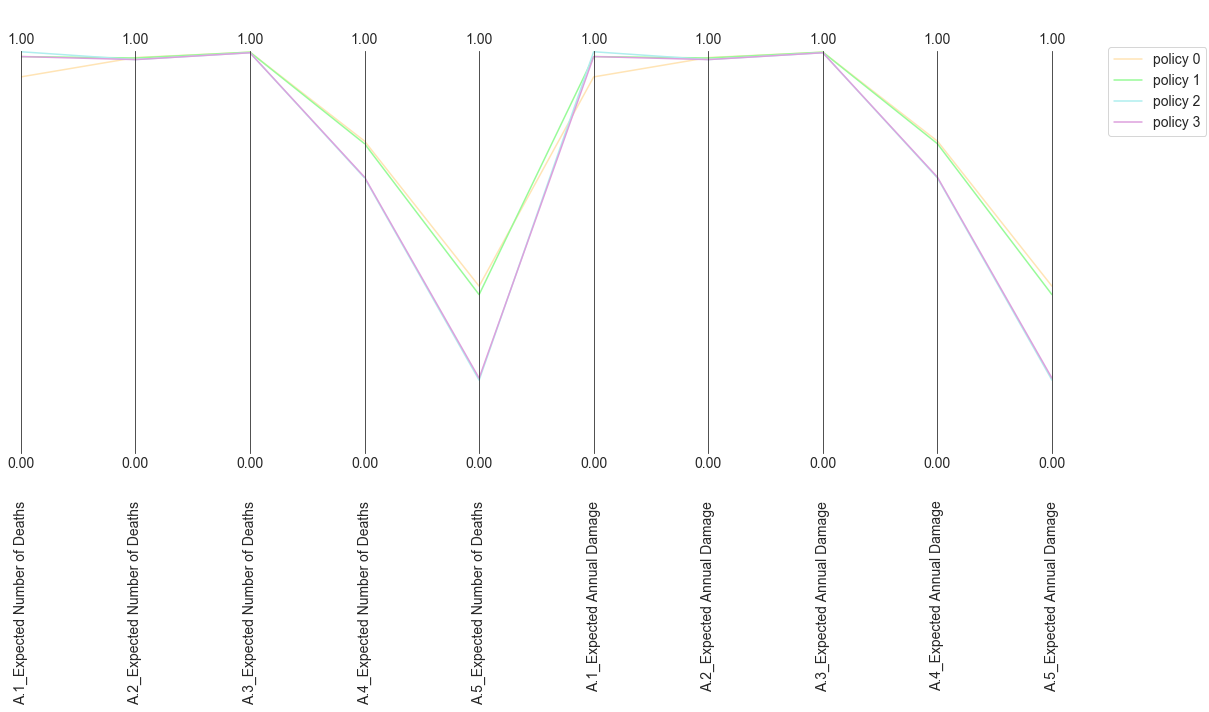

In [15]:
#results_df.head()
#for making parallel coordinate plots with damaage as objective we need to run with problem formulation 5
#since problem formulation 3 only has total costs as objective
n_scenarios = 2000
robustness_dict = {}
results_df['name'] = experiment['policy']
objectives = ['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths',
             'A.3_Expected Number of Deaths','A.4_Expected Number of Deaths',
             'A.5_Expected Number of Deaths','A.1_Expected Annual Damage',
             'A.2_Expected Annual Damage','A.3_Expected Annual Damage',
             'A.4_Expected Annual Damage','A.5_Expected Annual Damage']

for obj in objectives:
    robustness = []
    for i in range(0, len(results_df['name'].unique())):
        df_pol = results_df[results_df['name']==results_df['name'].unique()[i]]
        if ('Deaths' in obj):
            robustness_policy_outcome = len(df_pol[df_pol[obj]< 0.000002])/len(df_pol)
            robustness.append(robustness_policy_outcome)
        else:
            robustness_policy_outcome = len(df_pol[df_pol[obj]<20000])/len(df_pol)
            robustness.append(robustness_policy_outcome)
    robustness_dict[obj] = robustness 
robust_df = pd.DataFrame(data=robustness_dict)
limits = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1]], columns=objectives)
axes = parcoords.ParallelAxes(limits)
colors = ['moccasin','palegreen','paleturquoise','plum','khaki','lightsalmon','silver','darkseagreen']
for i in range(0,len(robust_df)):
    outcomes = robust_df.iloc[i]
    axes.plot(outcomes.to_frame().T,label='policy {}'.format(i),color = colors[i])
axes.fig.set_size_inches(15,10)
axes.legend()
plt.show()

In [24]:
results_df.columns

Index(['A.1_Expected Annual Damage 0', 'A.1_Dike Investment Costs 0',
       'A.1_Expected Number of Deaths 0', 'A.2_Expected Annual Damage 0',
       'A.2_Dike Investment Costs 0', 'A.2_Expected Number of Deaths 0',
       'A.3_Expected Annual Damage 0', 'A.3_Dike Investment Costs 0',
       'A.3_Expected Number of Deaths 0', 'A.4_Expected Annual Damage 0',
       'A.4_Dike Investment Costs 0', 'A.4_Expected Number of Deaths 0',
       'A.5_Expected Annual Damage 0', 'A.5_Dike Investment Costs 0',
       'A.5_Expected Number of Deaths 0', 'RfR Total Costs 0',
       'Expected Evacuation Costs 0', 'A.1_Expected Annual Damage 1',
       'A.1_Dike Investment Costs 1', 'A.1_Expected Number of Deaths 1',
       'A.2_Expected Annual Damage 1', 'A.2_Dike Investment Costs 1',
       'A.2_Expected Number of Deaths 1', 'A.3_Expected Annual Damage 1',
       'A.3_Dike Investment Costs 1', 'A.3_Expected Number of Deaths 1',
       'A.4_Expected Annual Damage 1', 'A.4_Dike Investment Costs 1',
   

In [26]:
results_df['name2'] = results_df['name']

In [123]:
results_df.columns

Index(['A.1_Expected Annual Damage 0', 'A.1_Dike Investment Costs 0',
       'A.1_Expected Number of Deaths 0', 'A.2_Expected Annual Damage 0',
       'A.2_Dike Investment Costs 0', 'A.2_Expected Number of Deaths 0',
       'A.3_Expected Annual Damage 0', 'A.3_Dike Investment Costs 0',
       'A.3_Expected Number of Deaths 0', 'A.4_Expected Annual Damage 0',
       'A.4_Dike Investment Costs 0', 'A.4_Expected Number of Deaths 0',
       'A.5_Expected Annual Damage 0', 'A.5_Dike Investment Costs 0',
       'A.5_Expected Number of Deaths 0', 'RfR Total Costs 0',
       'Expected Evacuation Costs 0', 'A.1_Expected Annual Damage 1',
       'A.1_Dike Investment Costs 1', 'A.1_Expected Number of Deaths 1',
       'A.2_Expected Annual Damage 1', 'A.2_Dike Investment Costs 1',
       'A.2_Expected Number of Deaths 1', 'A.3_Expected Annual Damage 1',
       'A.3_Dike Investment Costs 1', 'A.3_Expected Number of Deaths 1',
       'A.4_Expected Annual Damage 1', 'A.4_Dike Investment Costs 1',
   

In [27]:
results_df2 = results_df.iloc[:,35:50]

In [28]:
results_df2.columns

Index(['name2', 'A.1_Expected Annual Damage', 'A.2_Expected Annual Damage',
       'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage',
       'A.5_Expected Annual Damage', 'A.1_Expected Number of Deaths',
       'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths',
       'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'],
      dtype='object')

## 2) Box Plot

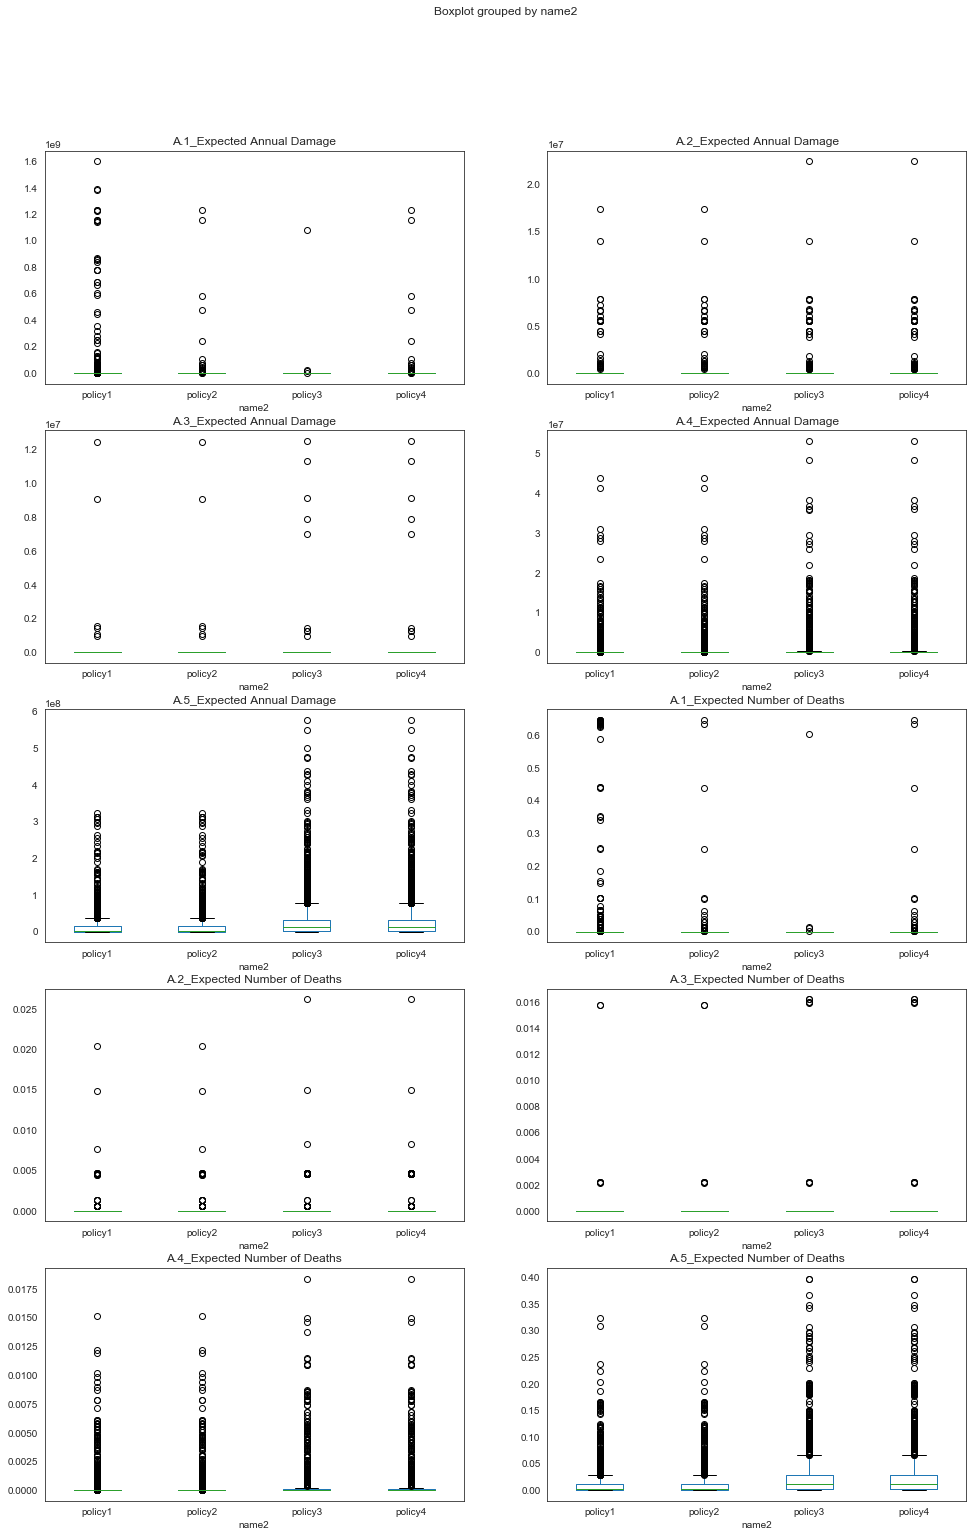

In [18]:
col = 2
row = 5
fig,ax = plt.subplots(row,col,figsize=(8*col,5*row))
location = list(itertools.product(range(row),range(col)))
fig.suptitle('Boxplots for each objective')
for i in range (0,len(results_df2.columns)-1):
    locat = location[i]
    results_df.boxplot(column=[results_df2.columns[i]],by='name2',ax = ax[locat],grid=False)

## 3)Pairplot for cost at each location

In [21]:
results_df2.columns

Index(['name2'], dtype='object')

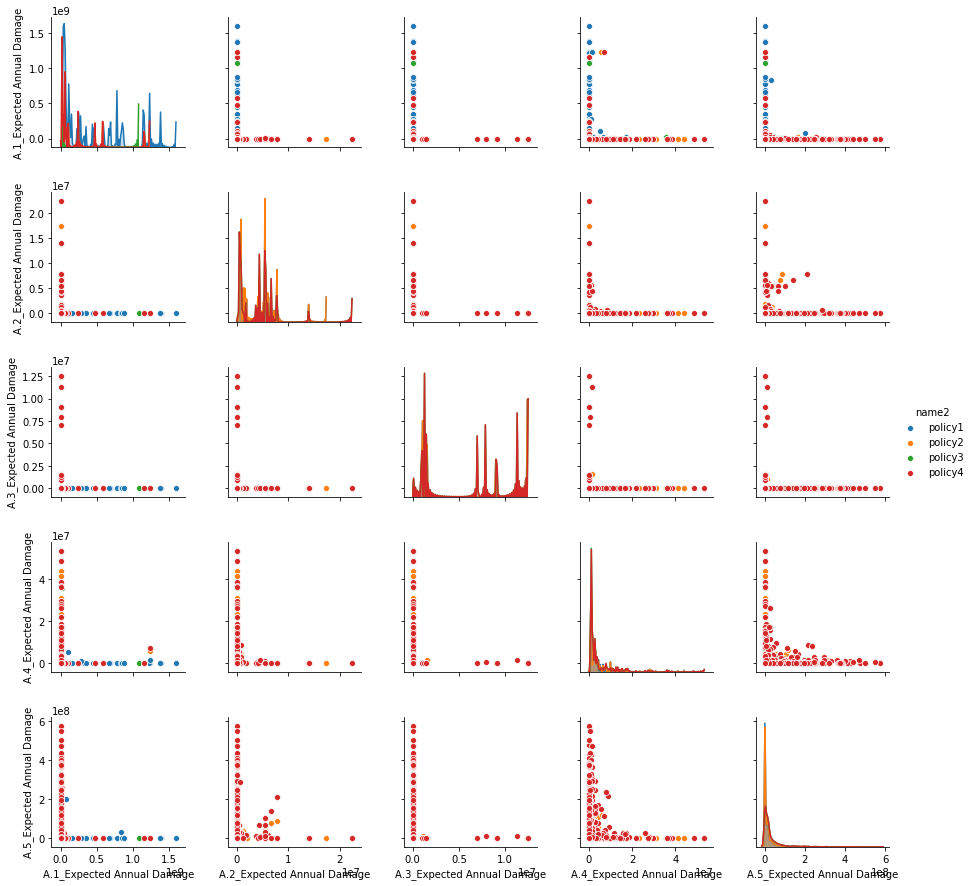

In [29]:
damage = results_df2[['A.1_Expected Annual Damage','A.2_Expected Annual Damage','A.3_Expected Annual Damage',
                     'A.4_Expected Annual Damage','A.5_Expected Annual Damage','name2']]
sns.pairplot(damage,hue='name2')

## 4) Pairplot for Deaths at each location

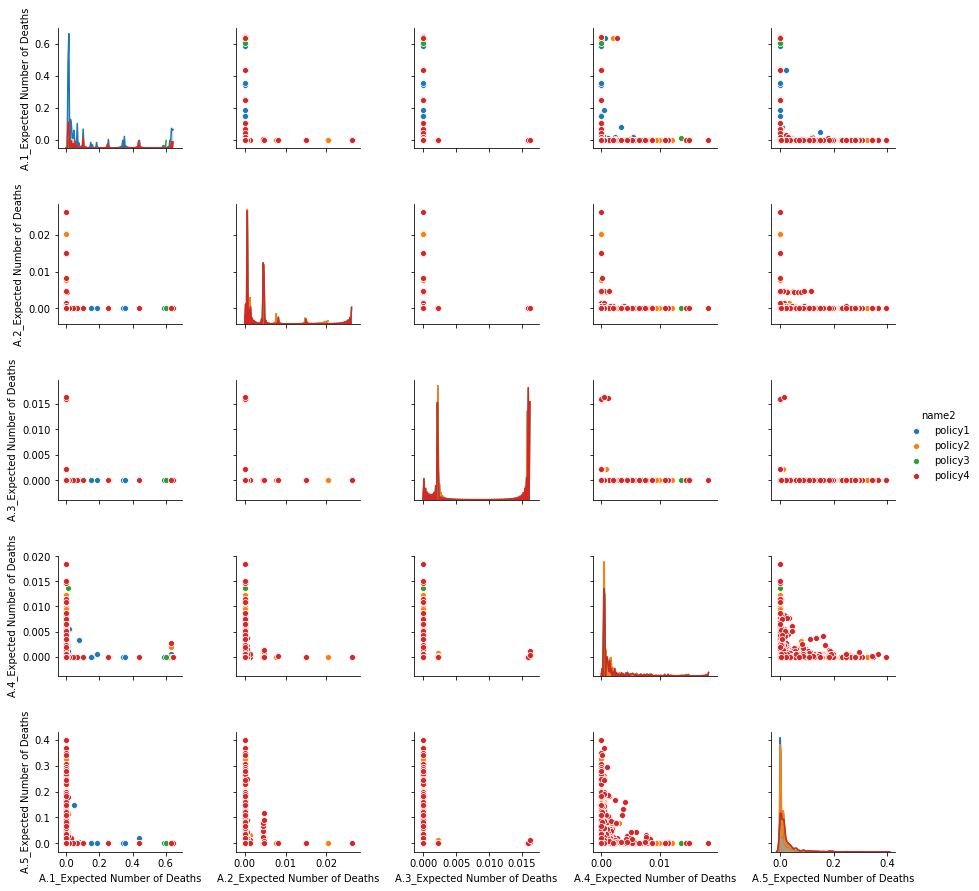

In [30]:
#Pairplot for death at each location
deaths = results_df2[['A.1_Expected Number of Deaths','A.2_Expected Number of Deaths','A.3_Expected Number of Deaths',
                      'A.4_Expected Number of Deaths','A.5_Expected Number of Deaths','name2']]
sns.pairplot(deaths,hue='name2')

## 5)Subspace partitioning

In [31]:
#Define the function for success of policy under a scenario and apply it to the results.The scripts for
#performing PRIM and dimensional stacking on all policies is below.Currently it shows error because 
#this "success" function is not defined properly
def success(df):
    for i in range (0,len(df)):
        if (df.loc[i,'A.1_Expected Number of Deaths']>0):
            a1 = 1
        else:
            a1 = 0
        if (df.loc[i,'A.2_Expected Number of Deaths']>0):
            a2 = 1
        else:
            a2 = 0
        if (df.loc[i,'A.3_Expected Number of Deaths']>0):
            a3 = 1
        else:
            a3 = 0
        if (df.loc[i,'A.4_Expected Number of Deaths']>0):
            a4 = 1
        else:
            a4 = 0
        if (df.loc[i,'A.5_Expected Number of Deaths']>0):
            a5 = 1
        else:
            a5 = 0
        if (df.loc[i,'A.1_Expected Annual Damage']>20000):
            a6 = 1
        else:
            a6 = 0
        if (df.loc[i,'A.2_Expected Annual Damage']>20000):
            a7 = 1
        else:
            a7 = 0
        if (df.loc[i,'A.3_Expected Annual Damage']>20000):
            a8 = 1
        else:
            a8 = 0
        if (df.loc[i,'A.4_Expected Annual Damage']>20000):
            a9 = 1
        else:
            a9 = 0
        if (df.loc[i,'A.5_Expected Annual Damage']>20000):
            a10 = 1
        else:
            a10 = 0

        if ((a1+a2+a3+a4+a5+a6+a7+a8+a9+a10)>3):
            df.loc[i,'success']=1
        else:
            df.loc[i,'success']=0


In [32]:
success(results_df)

In [33]:
len(results_df[results_df['success']==1])

1680

In [34]:
experiment['success'] = results_df['success']
diff_policies = {}
for i in range (0,len(experiment['policy'].unique())):
    df = experiment[experiment['policy']== experiment['policy'].unique()[i]]
    string = 'policy' + str(i)
    diff_policies[string] = df

In [13]:
#diff_policies['policy1']

In [35]:
#0:19
def prim_analysis(dict_pol):
    for key in dict_pol:
        df_prim = dict_pol[key]
        x = df_prim.ix[:,0:19]
        y = df_prim['success']
        y = y.values
        prim_alg = prim.Prim(x, y, threshold=0.1, peel_alpha=0.1)
        box1 = prim_alg.find_box()
        box1.show_tradeoff()
        plt.show()
        box1.inspect(style='graph')
        plt.show()
        box1.show_pairs_scatter()
        fig = plt.gcf()
        fig.set_size_inches(12,12)
        plt.show()
        dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
        plt.show()

        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
[MainProcess/INFO] 2000 points remaining, containing 298 cases of interest
[MainProcess/INFO] mean: 0.9612403100775194, mass: 0.0645, coverage: 0.4161073825503356, density: 0.9612403100775194 restricted_dimensions: 6


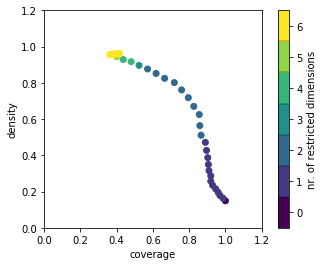

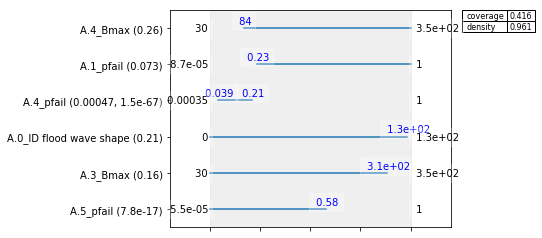

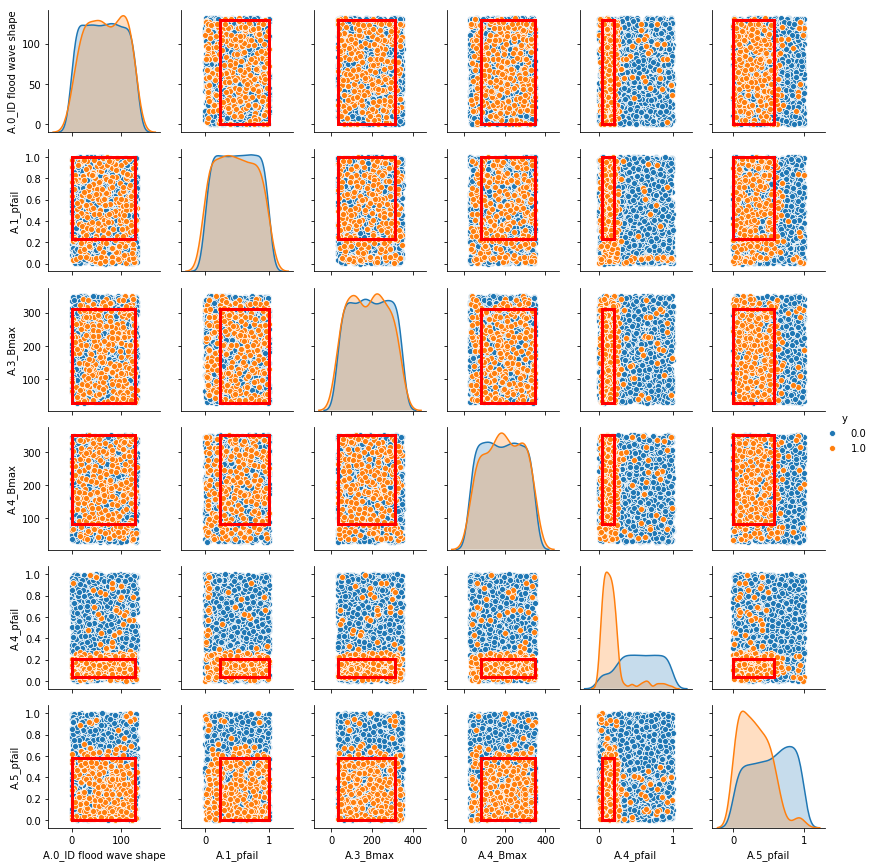

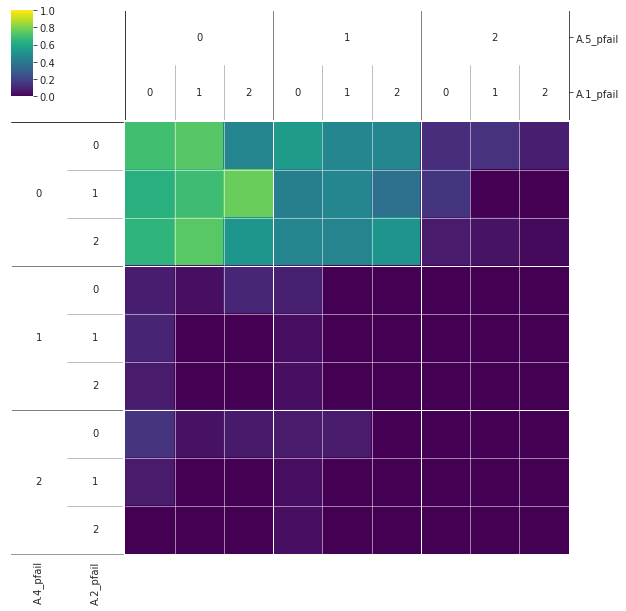

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
[MainProcess/INFO] 2000 points remaining, containing 286 cases of interest
[MainProcess/INFO] mean: 0.9642857142857143, mass: 0.056, coverage: 0.3776223776223776, density: 0.9642857142857143 restricted_dimensions: 4


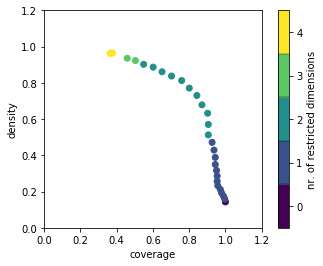

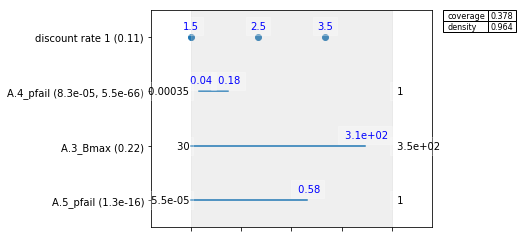

discount rate 1 [1.5, 2.5, 3.5, 4.5]


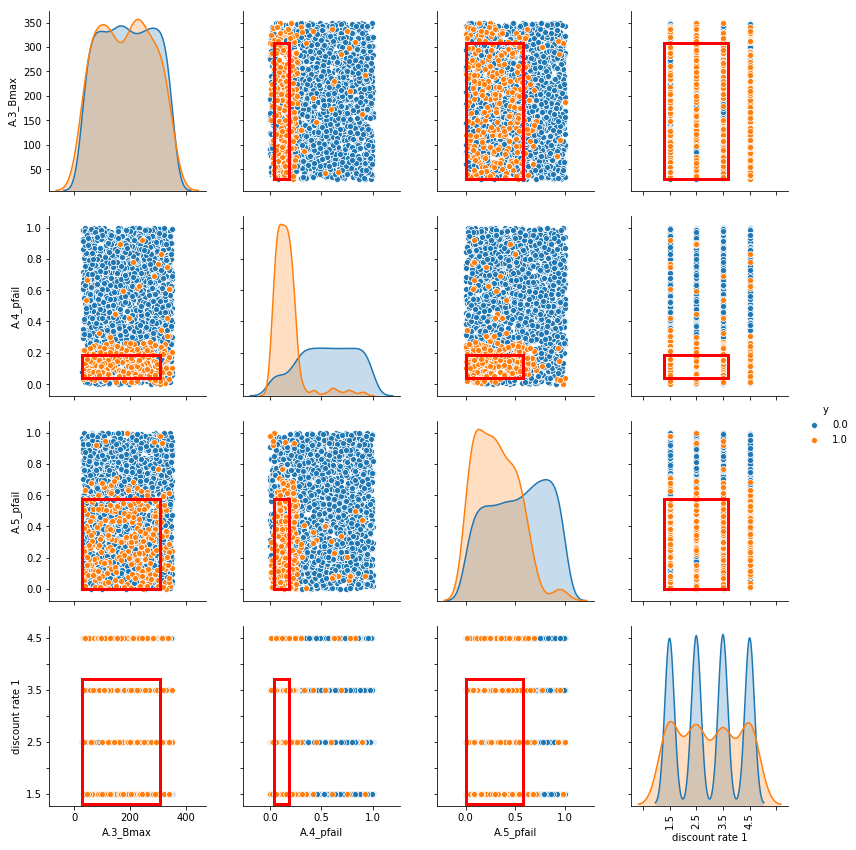

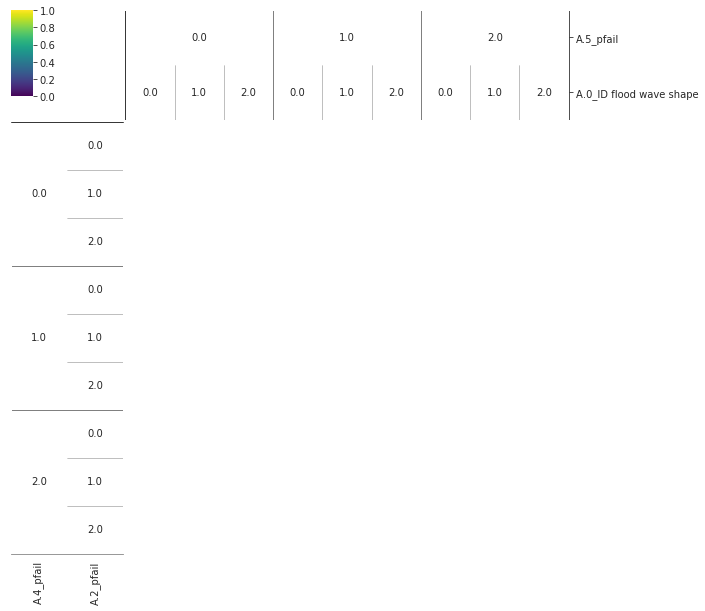

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
[MainProcess/INFO] 2000 points remaining, containing 546 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.097, coverage: 0.3553113553113553, density: 1.0 restricted_dimensions: 3


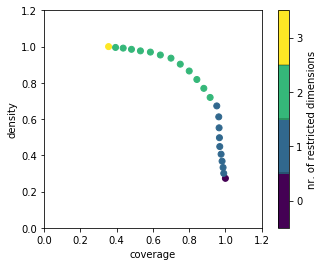

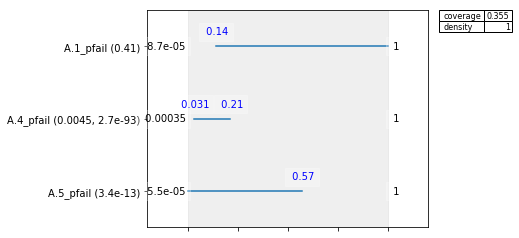

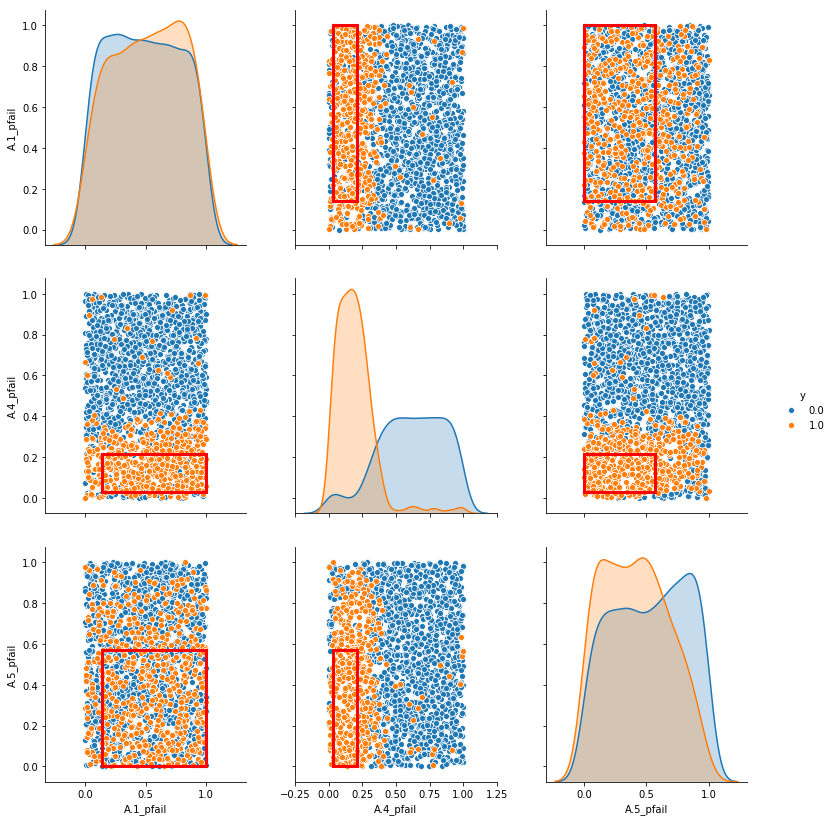

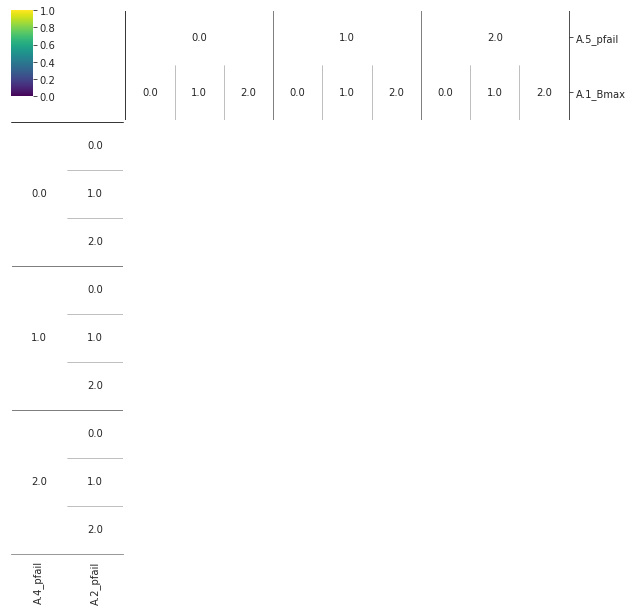

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
[MainProcess/INFO] 2000 points remaining, containing 550 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.097, coverage: 0.3527272727272727, density: 1.0 restricted_dimensions: 3


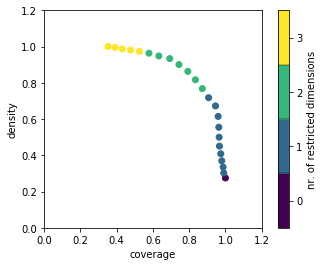

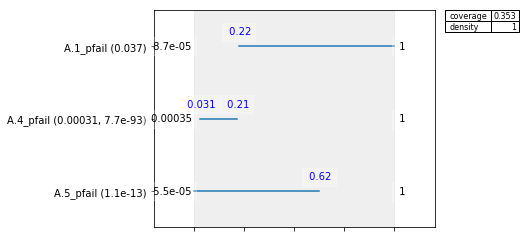

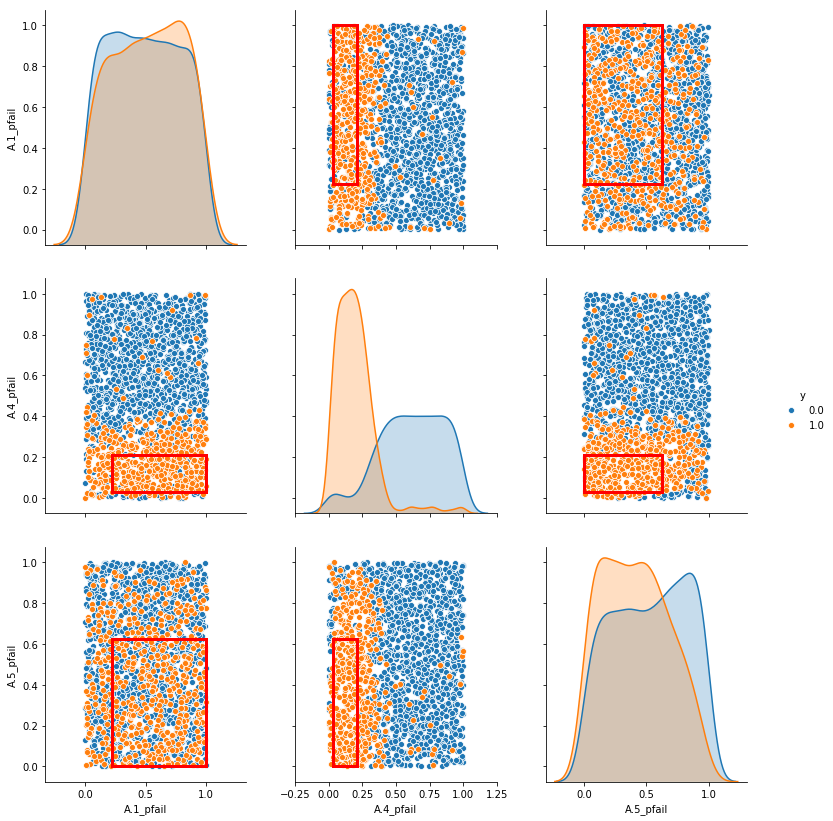

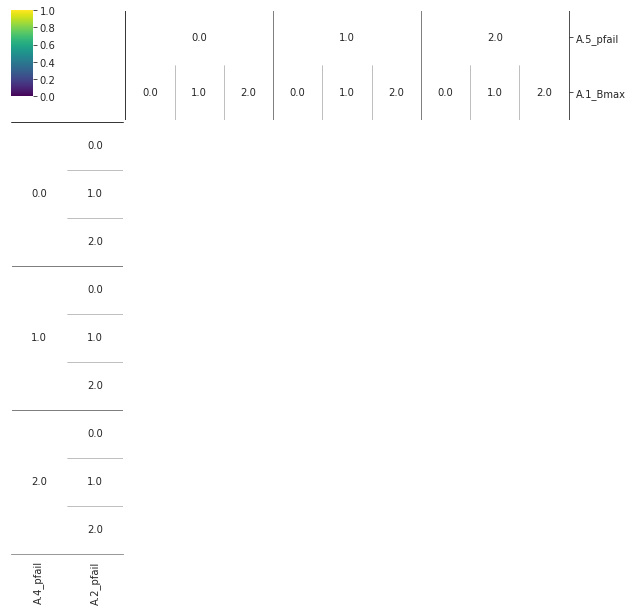

In [36]:
prim_analysis(diff_policies)

## Find the worst cases for failure

In [30]:
results_pol3 = results_df2[results_df2['name2']== 'policy3']
results_pol3['tot_dam'] = results_pol3['A.4_Expected Annual Damage']+results_pol3['A.5_Expected Annual Damage']
results_pol3['tot_death'] = results_pol3['A.4_Expected Number of Deaths']+results_pol3['A.5_Expected Number of Deaths']
results_pol3_dam = results_pol3[['A.4_Expected Annual Damage','A.5_Expected Annual Damage','A.4_Expected Number of Deaths','A.5_Expected Number of Deaths',
                                 'tot_dam','tot_death']]
experiment_pol3 = experiment[experiment['policy']=='policy3']
pol3_df = pd.concat([experiment_pol3,results_pol3_dam],axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
pol3_df = pol3_df.drop(['scenario','model','success'],axis=1)

In [32]:
pol3_df_a4_dam = pol3_df.sort_values(by=['A.4_Expected Annual Damage'],ascending=False)
pol3_df_a4_dam = pol3_df_a4_dam.reset_index()
pol3_df_a5_dam = pol3_df.sort_values(by=['A.5_Expected Annual Damage'],ascending=False)
pol3_df_a5_dam = pol3_df_a5_dam.reset_index()
pol3_df_tot_dam = pol3_df.sort_values(by=['tot_dam'],ascending=False)
pol3_df_tot_dam = pol3_df_tot_dam.reset_index()
pol3_df_a4_dea = pol3_df.sort_values(by=['A.4_Expected Number of Deaths'],ascending=False)
pol3_df_a4_dea = pol3_df_a4_dea.reset_index()
pol3_df_a5_dea = pol3_df.sort_values(by=['A.5_Expected Number of Deaths'],ascending=False)
pol3_df_a5_dea = pol3_df_a5_dea.reset_index()
pol3_df_tot_dea = pol3_df.sort_values(by=['tot_death'],ascending=False)
pol3_df_tot_dea = pol3_df_tot_dea.reset_index()


In [41]:
pol3_df_tot_dea.head(1)

,index,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1,policy,A.4_Expected Annual Damage,A.5_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,tot_dam,tot_death
0,5709,123.0,324.27821,10.0,0.715683,301.013066,1.0,0.832625,98.975745,1.5,...,3.0,3.0,0.0,policy3,0.0,3.665581e+08,0.0,0.396934,3.665581e+08,0.396934


In [42]:
scenario1=pol3_df_a4_dam.iloc[0]
scenario2=pol3_df_a5_dam.iloc[0]
scenario3 = pol3_df_tot_dam.iloc[0]
scenario4=pol3_df_a4_dea.iloc[0]
scenario5=pol3_df_a5_dea.iloc[0]
scenario6 = pol3_df_tot_dea.iloc[0]

In [112]:
scenario1

index                                4144
A.0_ID flood wave shape                29
A.1_Bmax                           325.13
A.1_Brate                              10
A.1_pfail                         0.62484
A.2_Bmax                          130.249
A.2_Brate                             1.5
A.2_pfail                         0.44526
A.3_Bmax                           92.368
A.3_Brate                               1
A.3_pfail                        0.777629
A.4_Bmax                          215.279
A.4_Brate                              10
A.4_pfail                      0.00146051
A.5_Bmax                          304.742
A.5_Brate                               1
A.5_pfail                        0.440325
discount rate 0                       1.5
discount rate 1                       1.5
0_RfR 0                                 0
0_RfR 1                                 0
1_RfR 0                                 0
1_RfR 1                                 0
2_RfR 0                           

In [44]:
scenarios = pd.concat([scenario1,scenario2,scenario3,scenario4,scenario5,scenario6],axis=1)

In [45]:
scenarios_tr=scenarios.T
scenarios_tr

,index,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1,policy,A.4_Expected Annual Damage,A.5_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Expected Number of Deaths,tot_dam,tot_death
0,4144,29,325.13,10,0.62484,130.249,1.5,0.44526,92.368,1,...,3,3,0,policy3,5.32108e+07,0,0.0145889,0,5.32108e+07,0.0145889
0,4313,27,329.236,10,0.924977,227.498,1.5,0.665921,85.854,10,...,3,3,0,policy3,0,5.75848e+08,0,0.305459,5.75848e+08,0.305459
0,4313,27,329.236,10,0.924977,227.498,1.5,0.665921,85.854,10,...,3,3,0,policy3,0,5.75848e+08,0,0.305459,5.75848e+08,0.305459
0,4940,31,89.9786,1.5,0.811729,217.862,1.5,0.82798,80.5588,1,...,3,3,0,policy3,4.84559e+07,0,0.0183665,0,4.84559e+07,0.0183665
0,4768,123,292.951,1.5,0.549189,68.5762,1.5,0.684893,184.32,1,...,3,3,0,policy3,0,4.08719e+08,0,0.396934,4.08719e+08,0.396934
0,5709,123,324.278,10,0.715683,301.013,1,0.832625,98.9757,1.5,...,3,3,0,policy3,0,3.66558e+08,0,0.396934,3.66558e+08,0.396934


In [85]:
scenarios_tr.columns

Index(['index', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate',
       'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax',
       'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail',
       'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0',
       'discount rate 1', '0_RfR 0', '0_RfR 1', '1_RfR 0', '1_RfR 1',
       '2_RfR 0', '2_RfR 1', '3_RfR 0', '3_RfR 1', '4_RfR 0', '4_RfR 1',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.3_DikeIncrease 0',
       'A.3_DikeIncrease 1', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'policy',
       'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage', 'tot_dam'],
      dtype='object')

In [50]:
scenarios_unc = scenarios_tr.iloc[:,1:19]
scenarios_unc

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1
0,29,325.13,10,0.62484,130.249,1.5,0.44526,92.368,1,0.777629,215.279,10,0.00146051,304.742,1,0.440325,1.5,1.5
0,27,329.236,10,0.924977,227.498,1.5,0.665921,85.854,10,0.70451,41.5513,1.5,0.565286,226.54,1.5,0.00650917,1.5,1.5
0,27,329.236,10,0.924977,227.498,1.5,0.665921,85.854,10,0.70451,41.5513,1.5,0.565286,226.54,1.5,0.00650917,1.5,1.5
0,31,89.9786,1.5,0.811729,217.862,1.5,0.82798,80.5588,1,0.323915,191.506,1,0.000513503,217.111,1,0.634293,3.5,1.5
0,123,292.951,1.5,0.549189,68.5762,1.5,0.684893,184.32,1,0.545961,46.0035,1.5,0.685392,101.507,10,0.000609594,3.5,3.5
0,123,324.278,10,0.715683,301.013,1,0.832625,98.9757,1.5,0.0679576,279.698,1.5,0.763476,146.404,1.5,5.47884e-05,4.5,3.5


In [52]:
uncertainty1 = scenarios_unc.iloc[3].to_dict()
uncertainty_loc4= Scenario('uncertainty1', **uncertainty1)
uncertainty2 = scenarios_unc.iloc[4].to_dict()
uncertainty_loc5= Scenario('uncertainty2', **uncertainty2)


In [10]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200, policies = 1)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
experiment,outcomes=results

In [ ]:

nfe_MORDM = 15000

epsilon = [10000, 10000,0.00001, 0.0001]

convergence_metrics = [HyperVolume(minimum=[0, 0, 0, 0], 
                                   maximum=[1,1,1,1]),
                       EpsilonProgress()]
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=nfe_MORDM, 
                                 searchover='levers',
                                 epsilons=epsilon,
                                 convergence=convergence_metrics,
                                 reference=uncertainty_loc4)

save_results(results, 'scenario_loc4 MORDMruns_worst case scenario.tar.gz')
results = load_results('scenario_loc4 MORDMruns_worst case scenario.tar.gz')

outcomes, convergence = results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')